In [5]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# nltk.download('punkt')

In [6]:
### Import the data

df = pd.read_csv('../../data/final/futurice_blog_data.csv', delimiter='\t')
print(df.info())

### Drop the rows that have NaN text:
df.dropna(subset=['text'], inplace=True)
# data = df['text']
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               814 non-null    object 
 1   title             814 non-null    object 
 2   time              786 non-null    object 
 3   category          782 non-null    object 
 4   text              805 non-null    object 
 5   pageviews         814 non-null    int64  
 6   unique_pageviews  814 non-null    int64  
 7   avg_time          814 non-null    float64
 8   bounce_rate       814 non-null    float64
 9   exit%             814 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 63.7+ KB
None


In [7]:
### Use for tokenize in the tf-idf. Taken from http://brandonrose.org/clustering#Visualizing-document-clusters

# Stemmer from nltk snowball stemmer
stemmer = SnowballStemmer("english")


def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [8]:
## Using tfidf_Vectorizer to calculate the tfidf matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])


c:\Users\dng09\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


[Text(0.5, 1.0, 'Best epsilon: 1.084')]

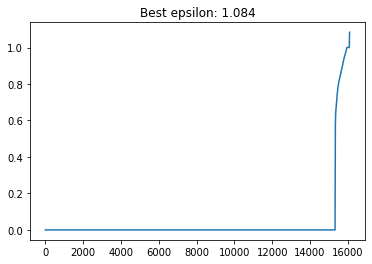

In [13]:
### Function for finding the best epsilon
## The feature matrix should be in the form of row matrix, meaning that each sample is in one row of the matrix
## k is the number of nearest point that the function will consider


def best_eps_cooking(feature_matrix,k=3):
    dist_matrix = pairwise_distances(feature_matrix)   # Pairwise distance of the samples
    
    min_dist_arr = np.zeros(dist_matrix.shape[0] * k)

    ## Find the 3 nearest distance for each of the samples
    for i in range(dist_matrix.shape[0]):
        nearest_k = np.sort(dist_matrix[i,:])[1:(1+k)]
        min_dist_arr[i:(i+k)] = nearest_k


    ## Finding the maximum slope of the distance, and return this value as the optimal epsilon
    eps = max([x - z for x, z in zip(min_dist_arr[:-1], min_dist_arr[1:])])

    return (eps, min_dist_arr)  # The dist_arr can be used to visualize the point,
    # return max_slope            # For compactness, use this return statement instead of the one before it


### Small test for the function
results = best_eps_cooking(tfidf_matrix, 20)
eps = results[0]
dist_sorted = np.sort(results[1])

sns.lineplot(data=dist_sorted).set(title="Best epsilon: {:.3f}".format(eps))

In [10]:
## Apply dbscan to the generated matrix
dbs = DBSCAN(eps=best_eps_cooking(tfidf_matrix)[0], min_samples=10, metric='cosine')
dbs.fit(tfidf_matrix)

DBSCAN(eps=1.0143545930246765, metric='cosine', min_samples=10)

In [11]:
### Create a dataframe that only contains the url, the category and the labels

df['label'] = dbs.labels_

clustered = df[['url', 'category', 'label']]
clustered.head()

clustered.groupby('label').size()

dist = pairwise_distances()


label
0    805
dtype: int64